In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, permutation_test_score
from scipy.stats import binom

sys.path.append('../')
from utils import utils

%matplotlib inline

In [2]:
# Load the data
iris = load_iris()

# Shuffle the data
X, y = shuffle(iris.data, iris.target)

In [3]:
# Build lda clf
lda = LinearDiscriminantAnalysis()
cross_val_score(lda, X, y)

array([1.        , 0.94117647, 1.        ])

In [4]:
# explore variation in CV scores
for i in range(10):
    X, y = shuffle(iris.data, iris.target)
    print(cross_val_score(lda, X, y))

[1.         0.96078431 0.97916667]
[0.98039216 0.98039216 1.        ]
[0.98039216 0.98039216 0.9375    ]
[0.98039216 0.96078431 1.        ]
[1.         0.96078431 0.97916667]
[0.96078431 0.98039216 1.        ]
[0.98039216 0.98039216 0.97916667]
[0.94117647 1.         1.        ]
[1.         0.96078431 0.97916667]
[0.96078431 0.98039216 1.        ]


Looks like CV accuracy varies between 0.92-1. We can think of this as binomial distribution experiment where for each sample, the prob. of success = p and we repeat this for all samples. Let's plot binomial PMF using p = 0.7

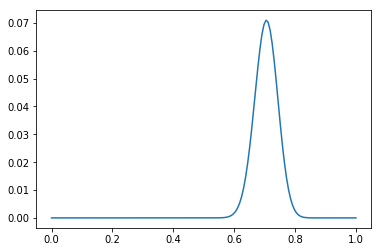

In [5]:
# Plot binomial pdf
n = len(iris.data)
distrib = binom(n=n, p=0.7)
plt.plot(np.linspace(0, 1, n), distrib.pmf(np.arange(n)))

The PMF is centered around 0.7, but it's width (variance) is not small which is the sampling noise and we can't do much about it.

In [6]:
# Plot binomial pdf
for n in [100, 1000, 10000, 100000]:
    distrib = binom(n=n, p=0.7)
    # Use 95% conf interval
    interval = (distrib.isf(0.025) - distrib.isf(0.975)) / n
    print(f'Size : {n: 7} | Interval : {interval:.2%}')

Size :     100 | Interval : 18.00%
Size :    1000 | Interval : 5.70%
Size :   10000 | Interval : 1.80%
Size :  100000 | Interval : 0.57%


In [7]:
# Dummy clf
dummy = DummyClassifier(strategy='stratified')
cross_val_score(dummy, X, y)

array([0.35294118, 0.45098039, 0.33333333])

In [8]:
# Use permutation to get a more robust baseline/chance score
lda = LinearDiscriminantAnalysis()
score, permutation, p_value = permutation_test_score(lda, X, y)
print(f'Score : {score:.2%}')
print(f'p_value : {p_value:.4f}')
print(f'Average permutation score : {np.mean(permutation):.2%}')
print(f'Permutation :\n{permutation}')

Score : 98.04%
p_value : 0.0099
Average permutation score : 33.21%
Permutation :
[0.38112745 0.33251634 0.2998366  0.3125     0.39338235 0.25939542
 0.2998366  0.30106209 0.36683007 0.37867647 0.28022876 0.40155229
 0.28594771 0.25367647 0.34027778 0.27941176 0.29861111 0.37377451
 0.2871732  0.34681373 0.31413399 0.33455882 0.35866013 0.36723856
 0.30678105 0.37214052 0.32638889 0.34599673 0.26756536 0.37908497
 0.30637255 0.29901961 0.34640523 0.27328431 0.30759804 0.3129085
 0.36764706 0.32026144 0.35334967 0.28594771 0.2871732  0.35253268
 0.28635621 0.35294118 0.2879902  0.31944444 0.35906863 0.31413399
 0.33864379 0.33864379 0.39215686 0.3120915  0.34722222 0.36887255
 0.38031046 0.23243464 0.33986928 0.29289216 0.29289216 0.34681373
 0.3255719  0.47303922 0.36111111 0.29084967 0.2994281  0.33986928
 0.34763072 0.27328431 0.30596405 0.30555556 0.25816993 0.35334967
 0.39379085 0.24591503 0.3002451  0.28635621 0.36111111 0.30555556
 0.38643791 0.35947712 0.30759804 0.26756536 0.36

The above shows that even with sample size of 100,000, we still have close to 0.6% of observations fall out of the 95% confidence interval.

**Bottom Line**: 
- CV score is not ground truth and it's just an estimation of the test error, i.e. it has its own error bars and uncertainty.
- Computing the variance on the folds errors is not a great estimate of the noise because the folds are not independent; however, it still gives us a rough estimate.
- Using CV to tune hyperparameters, Sklearn will refit the model using the best hyperparameters. However, we can get a more robust model if we pick the best hyperparameters on each fold and average them out --> become more like an ensemble.
- To get baseline/chance model score use:
    - Dummy classifier, it's more robust to use strategy=stratified to get more robust chance/baseline score.
    - Use permutation_test_score to get even more robust score. It permutates the target value and build classifier on permutated data.